In [ ]:
import json
import pandas as pd 
import numpy as np
import os
import re
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Ensure all densities are normalized to sum to 1
def normalize_density(density):
    return density / np.sum(density)
# Mutual Information calculation
def kl_divergence(p_density, q_density):
    p_density = normalize_density(p_density)
    q_density = normalize_density(q_density)
    return entropy(p_density, q_density)

# Count the number of elements in a list
def count_elements(item):
    if isinstance(item, list):
        return len(item)
    else:
        return 1

In [25]:
language_mapping = {
    'cantonese': 'CAN',
    'thai': 'THA',
    'japanese': 'JPN',
    'korean': 'KOR',
    'malay': 'MAL',
    'mandarin': 'MAN',
    'mono_eng': 'ENG',
    'urdu': 'URD'
}

real_language_mapping = {
    'HKG': 'CAN', 
    'THA': 'THA', 
    'JPN': 'JPN', 
    'KOR': 'KOR', 
    'MYS': 'MAL', 
    'CHN': 'MAN',  
    'ENS': 'ENG',  
    'PAK': 'URD',  
}

real_path_mapping = {'SD_1_Classified_Unmerged_qn': "Quantifiers Numerals",
                'SD_1_Classified_Unmerged_na': "Numbers Agreement",
                'SD_1_Classified_Unmerged_rw': "Reference Word",
                'SD_1_Classified_Unmerged_ta': "Tense Agreement",
                'SD_1_Classified_Unmerged_mve': "Modal Verbs Expressions",
                'SD_1_Classified_Unmerged_sva': "Subject Verb Agreement",
                'SD_1_Classified_Unmerged_sa': "Speech Acts",
                'SD_1_Classified_Unmerged_nvc': "Noun Verb Collocation"
                }

path_mapping = {'gpt_generation_quantifiers_numerals': "Quantifiers Numerals",
                'gpt_generation_tense_agreemen': "Tense Agreement",
                'gpt_generation_reference_word': "Reference Word",
                'gpt_generation_numbers_agreemen': "Numbers Agreement",
                'gpt_generation_speech_acts': "Speech Acts",
                'gpt_generation_subject_verb_agreemen': "Subject Verb Agreement",
                'gpt_generation_modal_verbs_expressions': "Modal Verbs Expressions",
                'gpt_generation_noun_verb_collocation': "Noun Verb Collocation"
                }

revert_mapping = {v: k for k, v in path_mapping.items()}
revert_real_mapping = {v: k for k, v in real_path_mapping.items()}

revert_lan_mapping = {v: k for k, v in language_mapping.items()}
revert_lan_real_mapping = {v: k for k, v in real_language_mapping.items()}

total_language_list = list(real_language_mapping.values())
real_language_list = list(real_language_mapping.keys())
total_feature_list = list(path_mapping.values())

In [23]:
# Put data under /data/gpt_annotations
path = '../data/gpt_annotations/'
for root, folders, files in os.walk(path):
    folder_list = folders
    break

# Put real data under /data/ICNALE_annotations
real_path = '../data/ICNALE_annotations'
for root, folders, files in os.walk(real_path):
    real_folder_list = folders
    break

In [26]:
# put the data under /data/gpt_annotations
eng_language = 'ENG'
res_table = pd.DataFrame(columns=total_feature_list)

for topic in total_feature_list:
    if topic == "Noun Verb Collocation":
        continue
    feature = revert_mapping[topic]
    pattern = r"([^/]+)_dialog$"
    path = f'../data/gpt_annotations/{feature}'

    all_data = pd.DataFrame()
    count = 0
    for root, _, files in os.walk(path):
        if count == 0:
            count = count+1
            continue 
        language = re.search(pattern, root).group(1)
        for json_file in files:
            if json_file.endswith('.json'):
                file_path = os.path.join(root, json_file)
                try:
                    data = pd.read_json(file_path)
                    filename = os.path.splitext(json_file)[0]
                    data['source_file'] = filename
                    data['language'] = language
                    all_data = pd.concat([all_data, data], ignore_index=True)
                except ValueError as e:
                    print(f"Error reading {file_path}: {e}")
        count = count + 1
        

    real_all_data = pd.DataFrame()
    def parse_filename(filename):
        pattern = r"SD_(\w+)_\d+_.*_(\d+)_([\w+]+)"
        match = re.match(pattern, filename)
        if match:
            language = match.group(1) 
            number = match.group(2)    
            chapter = match.group(3)   
            return language, number, chapter
        return None, None, None

    real_feature = revert_real_mapping[topic]
    real_path =  f'../data/ICNALE_annotations/{real_feature}'
    for root, _, files in os.walk(real_path):
        for json_file in files:
            if json_file.endswith('.json'):
                file_path = os.path.join(root, json_file)
                try:
                    data = pd.read_json(file_path)
                    filename = os.path.splitext(json_file)[0]
                    language, number, chapter = parse_filename(filename)
                    data['source_file'] = filename
                    data['language'] = language
                    data['number'] = number
                    data['chapter'] = chapter
                    real_all_data = pd.concat([real_all_data, data], ignore_index=True)
                except ValueError as e:
                    print(f"Error reading {file_path}: {e}")

    if topic == "Modal Verbs Expressions":   
        real_all_data['type'] = 'modal_verb_annotation'
    real_all_data =  real_all_data[real_all_data['language'].isin(real_language_list)]
        
    if feature in [revert_mapping['Reference Word'],
                revert_mapping['Numbers Agreement'],
                revert_mapping['Modal Verbs Expressions'],
                revert_mapping['Noun Verb Collocation']
    ]:
        all_data['token_num'] = 1
    else:
        all_data['token_num'] = all_data['annotation_token'].apply(count_elements)

    if real_feature in [revert_real_mapping['Reference Word'],
                revert_real_mapping['Numbers Agreement'],
                revert_real_mapping['Modal Verbs Expressions'],
                revert_real_mapping['Noun Verb Collocation']]:
        real_all_data['token_num'] = 1
    else:
        real_all_data['token_num'] = real_all_data['annotation_token'].apply(count_elements)
        
    real_counts = real_all_data.groupby(['language', 'source_file'])['token_num'].sum().reset_index()
    counts = all_data.groupby(['language', 'source_file'])['token_num'].sum().reset_index()


    for target_language in total_language_list:
        lang_counts = counts[counts['language'] == revert_lan_mapping[target_language]]['token_num']
        eng_lang_counts = counts[counts['language'] == revert_lan_mapping[eng_language]]['token_num']
        real_lang_counts = real_counts[real_counts['language'] == revert_lan_real_mapping[target_language]]['token_num']
        real_lang_ens_counts = real_counts[real_counts['language'] == revert_lan_real_mapping[eng_language]]['token_num']

        generated_l2_density = gaussian_kde(lang_counts)
        real_l2_density = gaussian_kde(real_lang_counts)
        mono_eng_density = gaussian_kde(eng_lang_counts)
        x_vals = np.linspace(min(real_lang_counts), max(real_lang_counts), 1000)

        l2_generated_gap = kl_divergence(generated_l2_density(x_vals), real_l2_density(x_vals))
        mono_eng_generated_gap = kl_divergence(mono_eng_density(x_vals), real_l2_density(x_vals))

        print(f"Topic: {topic} with L2: {target_language}")
        print(f"LLM L2 {target_language} Gap: {l2_generated_gap}")
        print(f"LLM Mono ENG Gap: {mono_eng_generated_gap}")
        print(f"*"*50)
        target_string = target_language + "_L2"
        compare_string =  target_language + "_Mono"
        res_table.loc[target_string, topic] = l2_generated_gap
        res_table.loc[compare_string, topic] = mono_eng_generated_gap

Topic: Quantifiers Numerals with L2: CAN
LLM L2 CAN Gap: 0.14497470573586485
LLM Mono ENG Gap: 0.7247848545105
**************************************************
Topic: Quantifiers Numerals with L2: THA
LLM L2 THA Gap: 0.049861418248560364
LLM Mono ENG Gap: 9.226827522442038
**************************************************
Topic: Quantifiers Numerals with L2: JPN
LLM L2 JPN Gap: 0.04449304480117997
LLM Mono ENG Gap: 1.954942215388575
**************************************************
Topic: Quantifiers Numerals with L2: KOR
LLM L2 KOR Gap: 0.03310274096087689
LLM Mono ENG Gap: 0.6543256910659426
**************************************************
Topic: Quantifiers Numerals with L2: MAL
LLM L2 MAL Gap: 0.006852119978909433
LLM Mono ENG Gap: 1.0390558086054753
**************************************************
Topic: Quantifiers Numerals with L2: MAN
LLM L2 MAN Gap: 0.027260405640483158
LLM Mono ENG Gap: 1.3816071172405104
**************************************************
Topic: Quant

In [28]:
res_table.to_csv('results.csv')

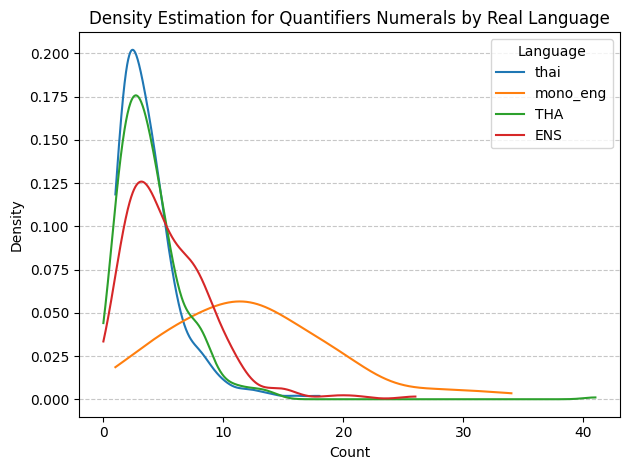

In [30]:
topic = "Quantifiers Numerals"
feature = revert_mapping[topic]
pattern = r"([^/]+)_dialog$"
path = f'../data/gpt_annotations/{feature}'

all_data = pd.DataFrame()
count = 0
for root, _, files in os.walk(path):
    if count == 0:
        count = count+1
        continue 
    language = re.search(pattern, root).group(1)
    for json_file in files:
        if json_file.endswith('.json'):
            file_path = os.path.join(root, json_file)
            try:
                data = pd.read_json(file_path)
                filename = os.path.splitext(json_file)[0]
                data['source_file'] = filename
                data['language'] = language
                all_data = pd.concat([all_data, data], ignore_index=True)
            except ValueError as e:
                print(f"Error reading {file_path}: {e}")
    count = count + 1
    
real_all_data = pd.DataFrame()
def parse_filename(filename):
    pattern = r"SD_(\w+)_\d+_.*_(\d+)_([\w+]+)"
    match = re.match(pattern, filename)
    if match:
        language = match.group(1) 
        number = match.group(2)    
        chapter = match.group(3)   
        return language, number, chapter
    return None, None, None

real_feature = revert_real_mapping[topic]
real_path =  f'../data/ICNALE_annotations/{real_feature}'
for root, _, files in os.walk(real_path):
    for json_file in files:
        if json_file.endswith('.json'):
            file_path = os.path.join(root, json_file)
            try:
                data = pd.read_json(file_path)
                filename = os.path.splitext(json_file)[0]
                language, number, chapter = parse_filename(filename)
                data['source_file'] = filename
                data['language'] = language
                data['number'] = number
                data['chapter'] = chapter
                real_all_data = pd.concat([real_all_data, data], ignore_index=True)
            except ValueError as e:
                print(f"Error reading {file_path}: {e}")

if topic == "Modal Verbs Expressions":   
    real_all_data['type'] = 'modal_verb_annotation'
real_all_data =  real_all_data[real_all_data['language'].isin(real_language_list)]
    
if feature in [revert_mapping['Reference Word'],
            revert_mapping['Numbers Agreement'],
            revert_mapping['Modal Verbs Expressions'],
            revert_mapping['Noun Verb Collocation']
]:
    all_data['token_num'] = 1
else:
    all_data['token_num'] = all_data['annotation_token'].apply(count_elements)

if real_feature in [revert_real_mapping['Reference Word'],
            revert_real_mapping['Numbers Agreement'],
            revert_real_mapping['Modal Verbs Expressions'],
            revert_real_mapping['Noun Verb Collocation']]:
    real_all_data['token_num'] = 1
else:
    real_all_data['token_num'] = real_all_data['annotation_token'].apply(count_elements)
    
real_counts = real_all_data.groupby(['language', 'source_file'])['token_num'].sum().reset_index()
counts = all_data.groupby(['language', 'source_file'])['token_num'].sum().reset_index()


languages = [revert_lan_mapping['THA'], revert_lan_mapping['ENG']]
real_languages = [revert_lan_real_mapping['THA'], revert_lan_real_mapping['ENG']]

for language in languages:
    lang_counts = counts[counts['language'] == language]['token_num']
    density = gaussian_kde(lang_counts)
    x_vals = np.linspace(min(lang_counts), max(lang_counts), 1000)
    y_vals = density(x_vals)
    plt.plot(x_vals, y_vals, label=language)
    
plt.title(f'Density Estimation for {topic} by Language')
plt.xlabel('Count')
plt.ylabel('Density')
plt.legend(title="Language")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.show()


for language in real_languages:
    lang_counts = real_counts[real_counts['language'] == language]['token_num']
    density = gaussian_kde(lang_counts)
    x_vals = np.linspace(min(lang_counts), max(lang_counts), 1000)
    y_vals = density(x_vals)
    plt.plot(x_vals, y_vals, label=language)
    
plt.title(f'Density Estimation for {topic} by Real Language')
plt.xlabel('Count')
plt.ylabel('Density')
plt.legend(title="Language")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()